# Function for creating neural networks

In [1]:
#first import libraries ,seaborn and sys could be removed . The other ones cannot be removed

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
import sys
sns.set(color_codes=True)
%matplotlib inline

In [2]:
#Libraries for reading csv files 
import os #library imported in order to read file in a specific location/folder
from csv import reader         # for reading csv files
from csv import writer         # for writing csv files

In [3]:
# libraries for preprocessing the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
#libraries for building the artificial neural networks(ANNs), imported from tensor flow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import GaussianNoise
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
# import metrics in order to measure performance of ANNs
from sklearn.metrics import r2_score, mean_squared_error

In [6]:
# choose between one of the following cases:'6D','4D_ethanol','4D_hydrogen','5D'
# Type first output that will be represented by ANN, for instance: ANN('SourcePV','6D')
def ANN(output,case):
    print(output) #check that output is being read correctly
    print(case)   #check that lookup table case is being read correctly
    X=pd.read_csv('Data/tables_'+case+'/inputs csv/inputs.csv',header=None).values #read inputs csv file using pandas, header=None, do not remove it
    y=pd.read_csv('Data/tables_'+case+'/outputs csv/'+output+'_table.csv',header=None).values #read outputs csv using file using pandas
    training_size_1=input("enter training size (value between 0-1,recommended=0.7):") #enter size of training set, 0.7 recommended
    X_train,X_val_test,y_train,y_val_test=train_test_split(X,y,test_size=1-float(training_size_1),random_state=0) #split inputs and outputs into train and valditation+test set 
    test_size_2=input("enter validation-test size (value between 0-1,recommended=0.5):") # enter size of validation and test set, 0.5 recommended 
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=float(test_size_2)) #defining test and validation sets
    min_scaler=np.min(y_train)   # compute minimum value of the output
    max_scaler=np.max(y_train)   # compute maximum value of the output
    scaler=MinMaxScaler()                          #instantiate MinMaxScaler
    y_train=scaler.fit_transform(y_train)          # first fit MinMaxScaler to the training inputs
    y_val=scaler.transform(y_val)                  # apply previous scaling to validation inputs
    y_test=scaler.transform(y_test)                # apply scaling to test inputs
    #building ANN
    model=Sequential() #instantiate model
    n_hidden_layers=input("enter number of hidden layers (integer number >=1):") #define number of hidden layers
    noise=input("do you want to add noise to inputs? (answers: 1:YES ,0=NO):")  #choice adding noise to inputs, recommended when data sets is small
    if int(noise)==1:
        noise_prop=input("enter noise standard deviation (value between 0-1,depends on data set, recommended=0.01):")  #enter standard deviation of the noise, distribute standard normal
        model.add(GaussianNoise(float(noise_prop),input_shape=(X_train.shape[1],)))  # adding noise to inputs
    dropout=input("do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO):") #choice if dropout regularization technique will be used, recommended for small data sets
    if int(dropout)==1:
        dropout_prop=input("enter dropout proportion (value between 0-1,recommended=0.2):") #enter proportion of neurons that will not be updated at each iteration
        model.add(Dropout(float(dropout_prop)))   #adding dropout technique in the model
    neurons_HL=input("enter number of neurons in first hidden layer:")  #enter number of neurons in the first hidden layer
    activation=input("enter activation function in first hidden layer (options:relu,tanh,sigmoid,linear,softmax, recommended=sigmoid):") #choice activation function recommended: sigmoid or relu
    model.add(Dense(units=int(neurons_HL),activation=activation,input_shape=(X_train.shape[1],))) #adding first hidden layer
    dropout=input("do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO):") #choice if dropout regularization technique will be used, recommended for small data sets
    if int(dropout)==1:
        dropout_prop=input("enter dropout proportion (value between 0-1,recommended=0.2):") #enter proportion of neurons that will not be updated at each iteration
        model.add(Dropout(float(dropout_prop))) #adding dropout technique in the model
    if int(n_hidden_layers)>1: #adding next hidden layers, same procedure that adding the first one
        for i in range(2,int(n_hidden_layers)+1):
            neurons_HL_1=input("enter number of neurons for next hidden layer:")
            activation=input("enter activation function for next hidden layer (options:relu,tanh,sigmoid,linear,softmax, recommended=relu):")
            model.add(Dense(units=int(neurons_HL_1),activation=activation))
            neurons_HL=neurons_HL+'-'+neurons_HL_1
            dropout=input("do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO):")
            if int(dropout)==1:
                dropout_prop=input("enter dropout proportion (value between 0-1,recommended=0.2):")
                model.add(Dropout(float(dropout_prop)))
    #print(neurons_HL)
    activation=input("enter activation function in last layer (options:relu,tanh,sigmoid,linear,softmax, recommended=relu):") #adding output layer, it is only required to define activation function  
    model.add(Dense(units=y_train.shape[1] , activation=activation)) #adding output layer, number of neurons in this layer is recognized automatically by the model
    model.summary()   #print summary of the model with total number of parameter to be learnt(optimized)
    optimizer=input("Choose optimizer: answers: 1=ADAM , 0=SGD:")  #choice optimizer scheme, Adam or SGD are the most widely used for updating the adaptive parameters
    if int(optimizer)==1:
        learning_rate=input("enter learning rate (value between 0-1, recommended:0.005):") #enter learning rate, recommended 0.005 
        optimizer=Adam(lr=float(learning_rate)) #instantiate Adam optimizer to the model
    else:
        learning_rate=input("enter learning rate (value between 0-1, recommended:0.005):")#enter learning rate, recommended 0.005
        optimizer=SGD(lr=float(learning_rate))  #instantiate SGD optimizer to the model
    model.compile(optimizer=optimizer, loss='mse') #adding optimizer and loss function in the model, for regression mse:mean squared error must be used
    patience=input("enter number of epochs waited until no improvement of loss functions is achieved:") #enter number of epochs that must be run until early stopping will be applied
    ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=int(patience)) #defining early stopping, monitor='val_loss' saved model every time loss function improves in validation set
    MC = ModelCheckpoint('best_model_'+output+'_'+case+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #saving best model when loss function decreases
    factor_reduced=input("enter factor which will be applied to learning rate in case that model is not improving(recommended=0.5):") #enter factor that will be applied to learning rate when loss function does not improve
    patience_2=input("enter number of epochs until learning rate will be reduced by the previous factor:") #number of epochs that will be run before reducing the learning rate by the previous factor
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=float(factor_reduced),patience=int(patience_2), min_lr=0.00001) #instantiate RocPlateau min_lr defined as the minimum learning rate that will be used
    batch=input("enter batch size (recommended:16 o 32):") #enter batch size: number of data points that will be used to update the adaptive parameters
    epochs=input("enter number of epochs:")  #enter number of epochs that will be run in order to find the best model 
    stime=time.time()  #introduced in order to measure the time spent on fitting the models
    hist=model.fit(X_train,y_train,batch_size=int(batch),epochs=int(epochs),validation_data=(X_val,y_val),callbacks=[ES, MC,reduce_lr]) #fit model to the training set 
    time_fitting=time.time()-stime  #measuring time spent of fitting the model in the training set
    print("Time for ANN fitting: %.3f"%(time_fitting)) #print training time
    model_evaluate=model.evaluate(X_test, y_test)  #evaluate model in test set, in order to check that the model is not suffering overfitting
    print(model_evaluate)  #print statistical measures: MSE and coeficient of determination
    plt.plot(hist.history['loss'])  #plot loss for training data
    plt.plot(hist.history['val_loss']) #plot loss for val_loss
    plt.title('Loss ANN'+' '+output+' '+case) #title fo the plot, output automatically added in the title
    plt.ylabel('Loss') #y-label, shows loss is the most common label, user can change it
    plt.xlabel('Epoch') #x-label, shows epochs
    plt.legend(['Train', 'Val'], loc='upper right') #legend
    plt.show()  #print loss plot
    mse_train=mean_squared_error(y_train,model.predict(X_train)) #computing mean square error on train set
    mse_test=mean_squared_error(y_test,model.predict(X_test)) #computing mean square error on test set
    r2_train=r2_score(y_train,model.predict(X_train))  #computing coefficient of determination on train set
    r2_test=r2_score(y_test,model.predict(X_test))  #computing coefficient of determination on test set
    print("mean square error training data: %.6f"% mse_train)   #print mean square error and coefficient of determination for train and test set
    print("mean square error test data: %.6f"% mse_test)
    print("R^2 training data: %.6f"% r2_train)
    print("R^2 test data: %.6f"% r2_test)
    # measuring time spent for ANN computing a new output for lookup tables of 4D,5D and 6D. Other lookup tables with different independent variables can be added manually
    if case.split('_')[0]=='4D':
        stime=time.time()
        print(model.predict([[0.05,0.1,0.03,0.45]]))
        time_prediction=time.time()-stime
    if case=='5D':
        stime=time.time()
        print(model.predict([[0.05,0.1,0.03,0.45,0]]))
        time_prediction=time.time()-stime
    if case=='6D':
        stime=time.time()
        print(model.predict([[0.05,0.1,0.03,0.45,0,0]]))
        time_prediction=time.time()-stime
    print("Time for ANN predicting: %.3f" % time_prediction) # print prediction time 
    # routine used to save information in a CSV file called 'Information_ANN_Architectures_'+case+'.csv', case:4D,5D or 6D
    with open('Information_ANN_Architectures_'+case+'.csv', 'r', newline='\n') as read_obj, \
    open('Information_ANN_Architectures_'+case+'_1.csv', 'w', newline='\n') as write_obj:
        lines=reader(read_obj)
        #print(lines)
        #Search output that its ANN information will be added to the information file
        for line in lines:
            if (line[0]!=output): 
                writer(write_obj).writerow(line)
            else:
                writer(write_obj).writerow([line[0],min_scaler,max_scaler,n_hidden_layers,neurons_HL,mse_train,mse_test,r2_train,r2_test,time_fitting,time_prediction])
    os.remove('Information_ANN_Architectures_'+case+'.csv') #remove older file
    #create new file with updated information
    with open('Information_ANN_Architectures_'+case+'_1.csv', 'r', newline='\n') as read_obj, \
        open('Information_ANN_Architectures_'+case+'.csv', 'w', newline='\n') as write_obj:
            lines=reader(read_obj)
            #print(lines)
            for line in lines:
                writer(write_obj).writerow(line)
    os.remove('Information_ANN_Architectures_'+case+'_1.csv')  #remove temporary file
    return model,min_scaler,max_scaler,n_hidden_layers,neurons_HL,ES,MC,batch,epochs,model_evaluate,mse_train,mse_test,r2_train,r2_test,time_fitting,time_prediction

OH
4D_hydrogen


enter training size (value between 0-1,recommended=0.7): 0.7
enter validation-test size (value between 0-1,recommended=0.5): 0.5
enter number of hidden layers (integer number >=1): 4
do you want to add noise to inputs? (answers: 1:YES ,0=NO): 0
do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO): 0
enter number of neurons in first hidden layer: 16
enter activation function in first hidden layer (options:relu,tanh,sigmoid,linear,softmax, recommended=relu): sigmoid
do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO): 0
enter number of neurons for next hidden layer: 16
enter activation function for next hidden layer (options:relu,tanh,sigmoid,linear,softmax, recommended=relu): sigmoid
do you want to add dropout in order to avoid overfitting? (answers: 1:YES ,0=NO): 0
enter number of neurons for next hidden layer: 16
enter activation function for next hidden layer (options:relu,tanh,sigmoid,linear,softmax, recommended=relu): sigmoid

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


Choose optimizer: answers: 1=ADAM , 0=SGD: 1
enter learning rate (value between 0-1, recommended:0.01): 0.005
enter number of epochs waited until no improvement of loss functions is achieved: 30
enter factor which will be applied to learning rate in case that model is not improving(recommended=0.5): 0.5
enter number of epochs until learning rate will be reduced by the previous factor: 5
enter batch size (recommended:16 o 32): 16
enter number of epochs: 200


Epoch 1/200
53989/54002 [============================>.] - ETA: 0s - loss: 5.3460e-04
Epoch 00001: val_loss improved from inf to 0.00010, saving model to best_model_OH_4D_hydrogen.h5
54002/54002 [==============================] - 48s 894us/step - loss: 5.3453e-04 - val_loss: 9.9375e-05
Epoch 2/200
53942/54002 [============================>.] - ETA: 0s - loss: 7.9882e-05
Epoch 00002: val_loss improved from 0.00010 to 0.00009, saving model to best_model_OH_4D_hydrogen.h5
54002/54002 [==============================] - 47s 869us/step - loss: 7.9873e-05 - val_loss: 9.4190e-05
Epoch 3/200
53980/54002 [============================>.] - ETA: 0s - loss: 5.5447e-05
Epoch 00003: val_loss improved from 0.00009 to 0.00005, saving model to best_model_OH_4D_hydrogen.h5
54002/54002 [==============================] - 45s 841us/step - loss: 5.5442e-05 - val_loss: 4.7096e-05
Epoch 4/200
53996/54002 [============================>.] - ETA: 0s - loss: 4.6107e-05
Epoch 00004: val_loss did not improve from 0.

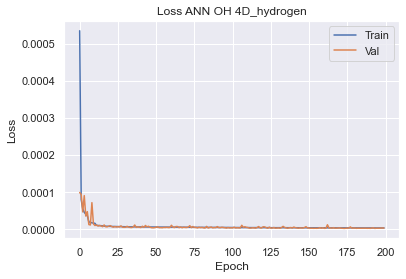

mean square error training data: 0.000004
mean square error test data: 0.000003
R^2 training data: 0.998724
R^2 test data: 0.998822
[[0.00063208]]
Time for ANN predicting: 0.076


(<tensorflow.python.keras.engine.sequential.Sequential at 0x1c8ecb8ee20>,
 0.0,
 0.0081876088980304,
 '4',
 '16-16-16-16',
 '16',
 '200',
 3.3363089642080013e-06,
 3.5633957387153757e-06,
 3.3363136886195057e-06,
 0.9987243860210994,
 0.9988224077805794,
 9146.847226142883,
 0.07598567008972168)

In [31]:
ANN('OH','4D_hydrogen')

# Plotting results

In [7]:
# function created in order to plot case 1: no fluctuations in mixture fraction and progress variable
# output vs scaled progress variable for different values of mixture fraction from lean to rich mixtures
# z_mean=array of different values of mixture fraction, output= dependent variable , for instance 'H2O', unit=unit of measurement for instance "[kg]"
# h=step progress variable, for instance h=0.01 implies that values of the scaled progress variable from 0,0.01,0.02,....,0.99,1 will be plotted
# case= lookup table dimensionality, for instance "4D_hydrogen"
# example: plot_case_1([0.2,0.3,0.5,0.7,0.8,0.9],0.1,'SourcePV','[-]','4D_hydrogen')

def plot_case_1(z_mean,h,output,unit,case):
    unit=str(unit)
    c_mean=np.linspace(0,1,int(1/h)+1) # create arrays of scaled progress variable
    output=str(output)
    # search minimum and maximum value of the output stored in file 'Information_ANN_Architectures_'+case+'.csv'
    with open('Information_ANN_Architectures_'+case+'.csv', 'r', newline='\n') as read_obj:
        lines=reader(read_obj)
        for line in lines:
            if (line[0]==output):
                a=float(line[1]) # minimum value
                b=float(line[2]) # maximum value
    # load ANN model corresponding to output that will be plotted
    model=load_model('best_model_'+output+'_'+case+'.h5') #'best_model_'+output+'.h5'
    # predictions using the ANN model the output for different values of scaled progress variable and mixture fraction, considering no fluctuations
    for z_m in z_mean:
        z=[]  #create list for prediction values
        for i in range(0,len(c_mean)):
            z1=model.predict(np.array([0,c_mean[i],0,z_m]).reshape(1,-1))[0][0] #ANN predicting values
            z.append((b-a)*z1+a) #scaled back the ANN values, ANN predicts values between 0 to 1, they need to be rescale using min and max values
        # search values stored in lookup tables
        PV=[] # empty array to store value that will be searched on the lookup table
        c=0.01*np.linspace(0,100,101) #  101 values corresponding to the scaled progress variable discretization stored in lookup table
        # uploading csv files containing dependend variables and the csv file which contains the output variable that will be plotted
        x1=pd.read_csv('Data/tables_'+case+'/inputs csv/inputs.csv',header=None).values # inputs file
        y1=pd.read_csv('Data/tables_'+case+'/outputs csv/'+output+'_table.csv',header=None).values #output file
        j=0
        # loop to search output values stored in the lookup table and store them in the array PV
        for i in range(0,x1.shape[0]):
            if x1[i][0]==0:
                if np.abs(x1[i][1]-c[j])<0.005:
                    if x1[i][2]==0:
                        if x1[i][3]==z_m:
                            PV.append(y1[i][0])
                            j=j+1
                            j=min(j,100)
        #plotting results
        z=np.array(z)# converting list to an array
        #print(z) #check z converted to a array (optional)
        z=z.reshape(len(c_mean),1) #converting to a column array
        #print(z) #check(optional)
        plt.plot(c, PV, 'r.', markersize=10, label='table') # plotting values stored in lookup table
        plt.plot(c_mean, z,'b-',label='predictions')  #plotting predictions
        plt.title('Results ANN'+' '+output+' case z='+str(z_m)+', var z=0,'+' var c=0') #defining titles
        plt.xlabel('c[-]')             #defining x-axis scaled progress variable
        plt.ylabel(output+unit)       #y-axis output
        plt.legend(loc='upper left')   #adding a legend
        plt.show()                      #show plot

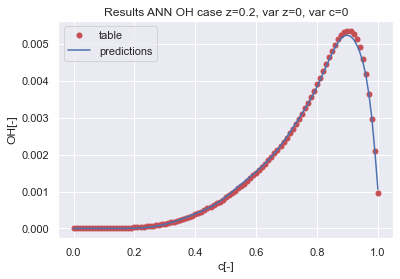

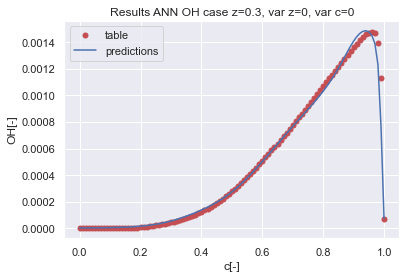

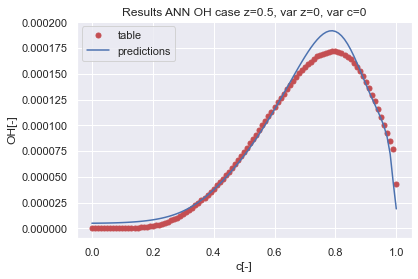

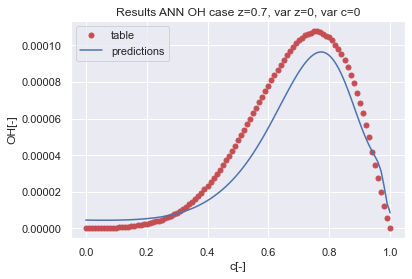

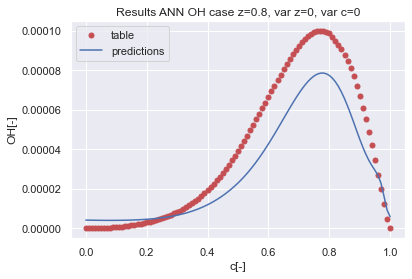

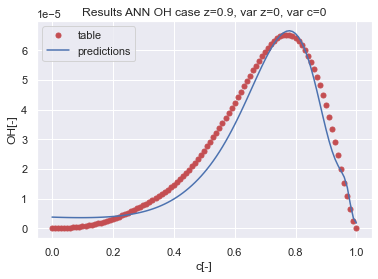

In [32]:
z_mean=[0.2,0.3,0.5,0.7,0.8,0.9]
plot_case_1(z_mean,0.01,'OH','[-]','4D_hydrogen')

In [8]:
# function created in order to plot case 2: fluctuations in mixture fraction at stoichiometric mixtres
# output vs variance of mixture fraction for different values of scaled progress variable for stocihiometric mixtures
# c_2= scaled progress variable, different values of the scaled progress variable. Typically high values of the scaled progress value
# z_var=array of different values of variance of mixture fraction, output= dependent variable , for instance 'H2O', unit=unit of measurement for instance "[kg]"
# h=step of variance of mixture fraction, for instance h=0.01 implies that values of the vairance of mixture fraction from 0,0.01,0.02,....,0.99,1 will be plotted
# case= lookup table dimensionality, for instance "4D_hydrogen"
# example: plot_case_2([0.8,0.85,0.9,0.95],0.01,'SourcePV','[-]','4D_hydrogen')

def plot_case_2(c_2,h,output,unit,case):
    z_sto=0.13 #stoichiometric mixture fraction
    z_var=np.linspace(0,1,int(1/h)+1) # array with different values of the variance of the mixture fraction
    output=str(output) # double check that output will be a string
    unit=str(unit) # double check that unit will be a string
    # search minimum and maximum value of the output stored in file 'Information_ANN_Architectures_'+case+'.csv'
    with open('Information_ANN_Architectures_'+case+'.csv', 'r', newline='\n') as read_obj:
        lines=reader(read_obj)
        for line in lines:
            if (line[0]==output):
                a=float(line[1]) # minimum value
                b=float(line[2]) # maximum value
    # load ANN model corresponding to output that will be plotted
    model=load_model('best_model_'+output+'_'+case+'.h5')
    # predictions using the ANN model the output for different values of variance of the mixture fraction, considering no fluctuations in scaled progress variable
    for c in c_2:
        z=[]  #create list for prediction values
        for i in range(0,len(z_var)):
            z1=model.predict(np.array([0,c,z_var[i],z_sto]).reshape(1,-1))[0][0] #ANN predicting values
            z.append((b-a)*z1+a) #scaled back the ANN values, ANN predicts values between 0 to 1, they need to be rescaled using min and max values
        # search values stored in lookup tables
        PV=[] # empty array to store value that will be searched on the lookup table
        z_var_plt=np.linspace(0,1,11) # 11 values corresponding to the variance of the mixture fraction stored in lookup table
        # uploading csv files containing dependend variables and the csv file which contains the output variable that will be plotted
        x1=pd.read_csv('Data/tables_'+case+'/inputs csv/inputs.csv',header=None).values # inputs file
        y1=pd.read_csv('Data/tables_'+case+'/outputs csv/'+output+'_table.csv',header=None).values # output file
        j=0
        # loop to search output values stored in the lookup table and store them in the array PV
        for i in range(0,x1.shape[0]):
            if x1[i][0]==0:
                if np.abs(x1[i][1]-c)<h/2:
                    if np.abs(x1[i][2]-z_var_plt[j])<h/2:
                        if x1[i][3]==z_sto:
                            PV.append(y1[i][0])
                            j=j+1
                            j=min(j,10)
        #plotting results
        z=np.array(z)# converting list to an array
        #print(z) #check z converted to a array (optional)
        z=z.reshape(len(z_var),1) #converting to a column array
        #print(z) #check(optional)
        plt.plot(z_var_plt, PV, 'r.', markersize=10, label='table') # plotting values stored in lookup table
        plt.plot(z_var, z,'b-',label='predictions')  #plotting predictions
        plt.title('Results ANN'+' '+output+' case c='+str(c)+', $z=z_{st}$,'+' var c=0') #defining titles
        plt.xlabel('variance z[-]')             #defining x-axis variance mixture fraction
        plt.ylabel(output+unit)       #y-axis output
        plt.legend(loc='upper right')   #adding a legend
        plt.show()                      #show plot

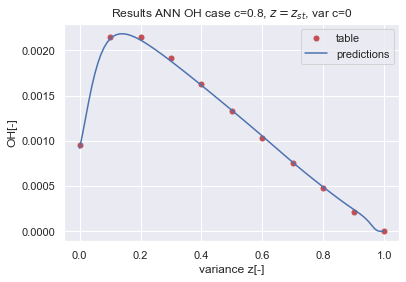

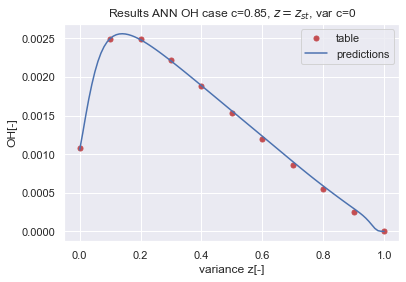

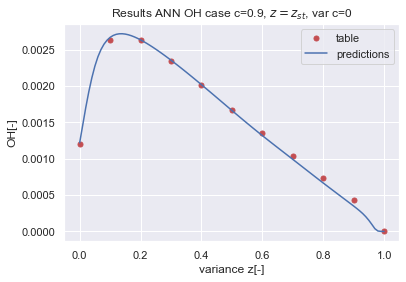

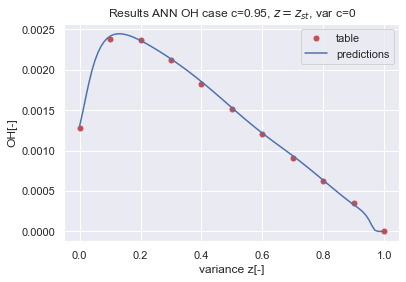

In [33]:
c_2=[0.8,0.85,0.9,0.95]
plot_case_2(c_2,0.01,'OH','[-]','4D_hydrogen')

In [9]:
# function created in order to plot case 3: fluctuations in scaled progress variable at stoichiometric mixture
# output vs variance of scaled progress variable for different values of scaled progress variable at stoichiometric mixture fraction
# c_3= scaled progress variable, different values of the scaled progress variable. Typically high values of the scaled progress value
# z_var=array of different values of variance of scaled progress variable, output= dependent variable , for instance 'H2O', unit=unit of measurement for instance "[kg]"
# h=step of variance of scaled progress variable, for instance h=0.01 implies that values of the variance of the scaled progress variable from 0,0.01,0.02,....,0.99,1 will be plotted
# case= lookup table dimensionality, for instance "4D_hydrogen"
# example: plot_case_3([0.8,0.85,0.9,0.95],0.01,'SourcePV','[-]','4D_hydrogen')

def plot_case_3(c_3,h,output,unit,case):
    z_sto=0.13 #stoichiometric mixture fraction
    c_var=np.linspace(0,1,int(1/h)+1) # array with different values of the variance of the mixture fraction
    output=str(output) # double check that output will be a string
    unit=str(unit) # double check that unit will be a string
    # search minimum and maximum value of the output stored in file 'Information_ANN_Architectures_'+case+'.csv'
    with open('Information_ANN_Architectures_'+case+'.csv', 'r', newline='\n') as read_obj:
        lines=reader(read_obj)
        for line in lines:
            if (line[0]==output):
                a=float(line[1]) # minimum value
                b=float(line[2]) # maximum value
    # load ANN model corresponding to output that will be plotted
    model=load_model('best_model_'+output+'_'+case+'.h5')
    # predictions using the ANN model the output for different values of variance of the scaled progress variable, considering no fluctuations in mixture fraction
    for c in c_3:
        z=[]  #create list for prediction values
        for i in range(0,len(c_var)):
            z1=model.predict(np.array([c_var[i],c,0,z_sto]).reshape(1,-1))[0][0] #ANN predicting values
            z.append((b-a)*z1+a) #scaled back the ANN values, ANN predicts values between 0 to 1, they need to be rescaled using min and max values
        # search values stored in lookup tables
        PV=[] # empty array to store value that will be searched on the lookup table
        c_var_plt=np.linspace(0,1,11) # 11 values corresponding to the variance of the scaled progress variable stored in lookup table
        # uploading csv files containing dependend variables and the csv file which contains the output variable that will be plotted
        x1=pd.read_csv('Data/tables_'+case+'/inputs csv/inputs.csv',header=None).values # inputs file
        y1=pd.read_csv('Data/tables_'+case+'/outputs csv/'+output+'_table.csv',header=None).values # output files
        j=0
        # loop to search output values stored in the lookup table and store them in the array PV
        for i in range(0,x1.shape[0]):
            if np.abs(x1[i][0]-c_var_plt[j])<h/2:
                if np.abs(x1[i][1]-c)<h/2:
                    if x1[i][2]==0:
                        if x1[i][3]==z_sto:
                            PV.append(y1[i][0])
                            j=j+1
                            j=min(j,10) 
        #plotting results
        z=np.array(z)# converting list to an array
        #print(z) #check z converted to a array (optional)
        z=z.reshape(len(c_var),1) #converting to a column array
        #print(z) #check(optional)
        plt.plot(c_var_plt, PV, 'r.', markersize=10, label='table') # plotting values stored in lookup table
        plt.plot(c_var, z,'b-',label='predictions')  #plotting predictions
        #plt.ylim([0, np.max(z)+0.1])
        plt.title('Results ANN'+' '+output+' case c='+str(c)+', $z=z_{st}$,'+' var z=0') #defining titles
        plt.xlabel('variance c[-]')             #defining x-axis variance scaled progress variable
        plt.ylabel(output+unit)       #y-axis output
        plt.legend(loc='upper right')   #adding a legend
        plt.show()                      #show plot

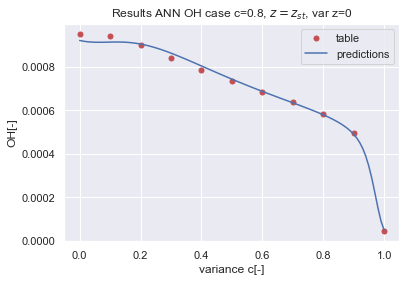

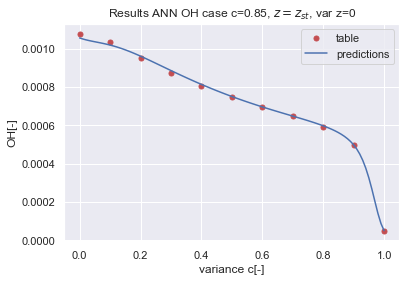

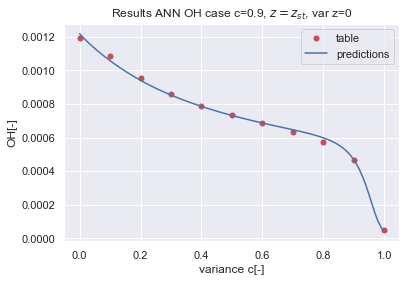

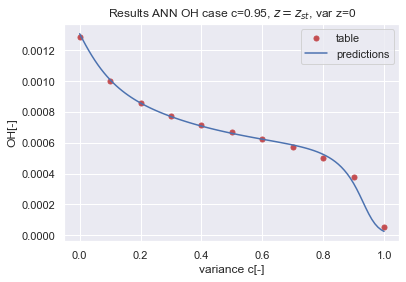

In [34]:
c_3=[0.8,0.85,0.9,0.95]
plot_case_3(c_3,0.01,'OH','[-]','4D_hydrogen')